# Plots for Needle in Haystack Tests

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import pickle
from datetime import datetime

#### Experiment Details

In [3]:
valA = "ortho"
valC = "_ident_C"
state_dim = 5
ckpt_step = 255000
experiment = "241231_175136.793356_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load


path = f"../outputs/GPT2/{experiment}/prediction_errors{valC}_step={ckpt_step}.ckpt/{valA}_state_dim_{state_dim}_err_lss_examples.pkl"
print(f"path: {path}")

path: ../outputs/GPT2/241231_175136.793356_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=255000.ckpt/ortho_state_dim_5_err_lss_examples.pkl


#### load the err_lss_examples at path which is numpy array

In [ ]:
with open(path, "rb") as f:
    err_lss_examples = pickle.load(f)

for key in err_lss_examples.keys():
    print(f"shape of {key}: {err_lss_examples[key].shape}")

shape of MOP: (5, 19, 2000, 251)
shape of Zero: (5, 19, 2000, 251)
shape of Analytical_Kalman: (5, 19, 251)
shape of Analytical_Simulation: (5, 19, 2000, 251)


#### Compute the Quartiles

In [13]:
quartiles = {}
for key in err_lss_examples.keys():
    if not key == "Analytical_Kalman":
        med = np.median(err_lss_examples[key], axis=2)
        print(f"shape of med: {med.shape}")
        quartiles[key] = np.percentile(med, [25,50,75], axis=0)
        print(f"shape of quartiles[{key}]: {quartiles[key].shape}")

shape of med: (5, 19, 251)
shape of quartiles[MOP]: (3, 19, 251)


/home/sultand/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


shape of med: (5, 19, 251)
shape of quartiles[Zero]: (3, 19, 251)
shape of med: (5, 19, 251)
shape of quartiles[Analytical_Simulation]: (3, 19, 251)


## Plottting Code

### final trace

haystack_len: 19


Text(0.5, 0.1, 'step=255000_20250109_041922')

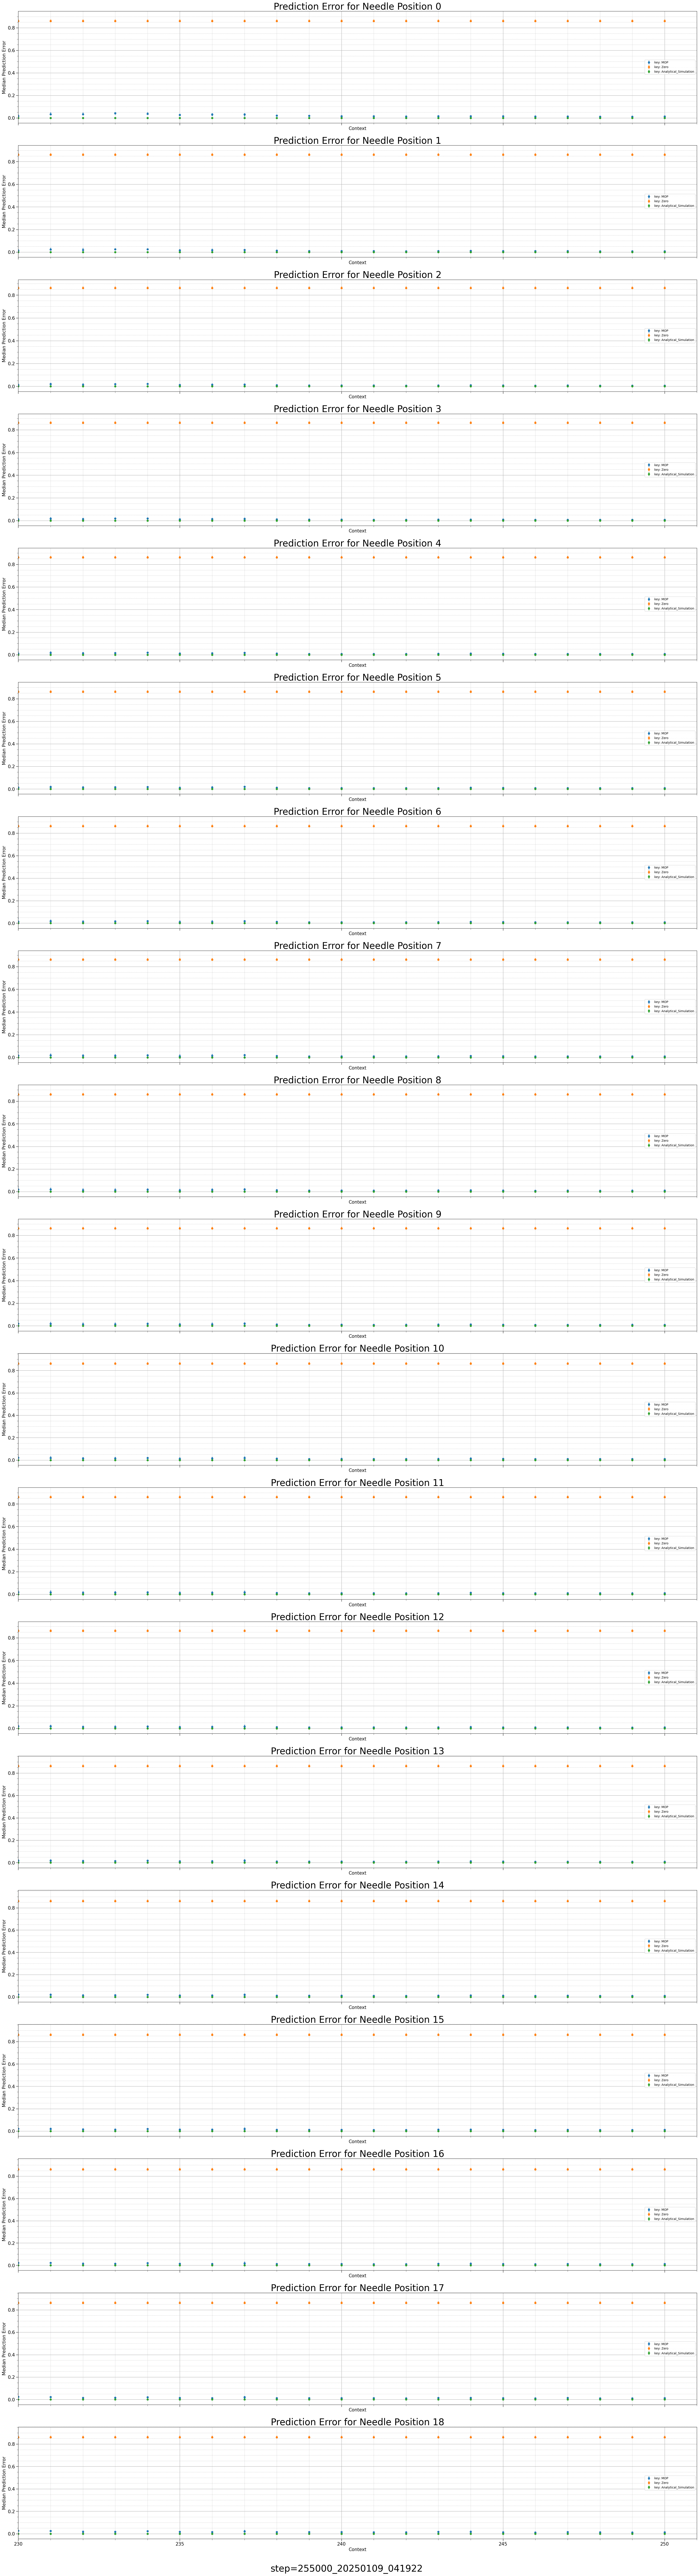

In [35]:
haystack_len = quartiles["MOP"].shape[1]
#make a figure with haystack_len subplots
fig, ax = plt.subplots(haystack_len, 1, sharex=True, figsize=(40, 150))
print(f"haystack_len: {haystack_len}")
for needle in range(haystack_len):
    for key in quartiles.keys():
        # ax[needle].scatter(quartiles[key][1, needle], label=key)
        ax[needle].errorbar(np.arange(quartiles[key].shape[-1]), quartiles[key][1, needle], yerr=[quartiles[key][1, needle] - quartiles[key][0, needle], quartiles[key][2, needle] - quartiles[key][1, needle],], fmt='o', label=f"{key}", capsize=2)
    ax[needle].legend()
    ax[needle].grid(which="both")
    ax[needle].set_xlim(left=haystack_len*12 + 2, right=quartiles[key].shape[-1])  # set the x axis limits
    # ax[needle].set_ylim(bottom=0, top=5.5)  # set the y axis limits


    # Optionally, customize major and minor ticks
    ax[needle].minorticks_on()

    # Set minor vertical grid lines to be on intervals of 1
    # Set major ticks on every interval of 50
    ax[needle].set_xticks(range(int(ax[needle].get_xlim()[0]), int(ax[needle].get_xlim()[1]) + 1, 5))

    # Set minor vertical grid lines to be on intervals of 1
    ax[needle].set_xticks(range(int(ax[needle].get_xlim()[0]), int(ax[needle].get_xlim()[1]) + 1, 1), minor=True)

    ax[needle].tick_params(axis='both', which='major', length=7, width=1, labelsize=20)
    ax[needle].tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
    ax[needle].grid(which='major', linestyle='-', linewidth=1)
    ax[needle].grid(which='minor', linestyle='--', linewidth=0.5)
    ax[needle].set_ylabel("Median Prediction Error", fontsize=20)
    ax[needle].set_xlabel("Context", fontsize=20)
    ax[needle].set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

#add a caption to the bottom of the figure
fig.text(0.5, 0.1, "step=" + str(ckpt_step) + "_" + timestamp, ha='center', fontsize=30)